Install the necessary modules

In [1]:
'''%pip install -q pandas
%pip install -q pyodbc 
%pip install -q python-dotenv
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q plotly
%pip install -q nbformat
%pip install -q statsmodels
%pip install -q dash
%pip install - qwordcloud
%pip install keras
#%pip install Cython
#%pip install tensorflow
#%pip install keras-tuner
#%pip install pmdarima
#%pip install scikeras
#%pip install pmdarima
#%pip install keras-tuner
#%pip install scikeras

'''

'%pip install -q pandas\n%pip install -q pyodbc \n%pip install -q python-dotenv\n%pip install -q matplotlib\n%pip install -q seaborn\n%pip install -q plotly\n%pip install -q nbformat\n%pip install -q statsmodels\n%pip install -q dash\n%pip install - qwordcloud\n%pip install keras\n#%pip install Cython\n#%pip install tensorflow\n#%pip install keras-tuner\n#%pip install pmdarima\n#%pip install scikeras\n#%pip install pmdarima\n#%pip install keras-tuner\n#%pip install scikeras\n\n'

Import all the necessary packages

In [3]:

import pyodbc
from dotenv import dotenv_values

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns

import scipy.stats as stats
from scipy.stats import mode

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import qqplot

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

from keras.models import Sequential
from keras.layers import Dense, LSTM
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from scipy.stats import randint
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Dropout







# Load Remote Dataset

In [4]:
'''environment_variables = dotenv_values('.env')

# getting the values of the variables stored in the .env file
database = environment_variables.get('DATABASE')
server   = environment_variables.get('SERVER')
username = environment_variables.get('USERNAME')
password = environment_variables.get('PASSWORD')

# below we are creating a connection string 
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

# belowe we are using the connection string to connect to the server
connection = pyodbc.connect(connection_string)

# Now the sql query to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query1 = "Select * from dbo.oil"
query2 = "Select * from dbo.stores"
query3 = "Select * from dbo.holidays_events"

# Read the sql data into dataframes
oil = pd.read_sql(query1, connection)
stores = pd.read_sql(query2, connection)
holidays_events = pd.read_sql(query3, connection)

oil.to_csv("oil.csv", index=False)
stores.to_csv("stores.csv", index=False)
holidays_events.to_csv("holidays_events", index=False)'''


'environment_variables = dotenv_values(\'.env\')\n\n# getting the values of the variables stored in the .env file\ndatabase = environment_variables.get(\'DATABASE\')\nserver   = environment_variables.get(\'SERVER\')\nusername = environment_variables.get(\'USERNAME\')\npassword = environment_variables.get(\'PASSWORD\')\n\n# below we are creating a connection string \nconnection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"\n\n# belowe we are using the connection string to connect to the server\nconnection = pyodbc.connect(connection_string)\n\n# Now the sql query to get the data is what what you see below. \n# Note that you will not have permissions to insert delete or update this database table. \n\nquery1 = "Select * from dbo.oil"\nquery2 = "Select * from dbo.stores"\nquery3 = "Select * from dbo.holidays_events"\n\n# Read the sql data into dataframes\noil = pd.read_sql(query1, connection)\nstores = pd.read_sql(query2, connection)\n

In [5]:
# redefining the datatypes in the columns to be sure 

dtypes = {'id':'int64', 'store_nbr':'int8', 'onpromotion':str}

In [6]:
# loading our datasets
data_oil = pd.read_csv("oil.csv", parse_dates=['date'])
df_stores = pd.read_csv('stores.csv')
df_holidays_events = pd.read_csv('holidays_events.csv', dtype={'transferred': str}, parse_dates=['date'])
df_train = pd.read_csv('train.csv', dtype=dtypes, parse_dates=['date'])
df_test = pd.read_csv('test.csv', dtype=dtypes, parse_dates=['date'])
df_transactions = pd.read_csv('transactions.csv', parse_dates=['date'])

# Train Data

In [7]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
df_train.shape

(3000888, 6)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int8          
 3   family       object        
 4   sales        float64       
 5   onpromotion  object        
dtypes: datetime64[ns](1), float64(1), int64(1), int8(1), object(2)
memory usage: 117.3+ MB


In [10]:
df_train.describe()

,id,store_nbr,sales
count,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02
std,8.662819e+05,1.558579e+01,1.101998e+03
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01
75%,2.250665e+06,4.100000e+01,1.958473e+02
max,3.000887e+06,5.400000e+01,1.247170e+05


In [11]:
df_train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

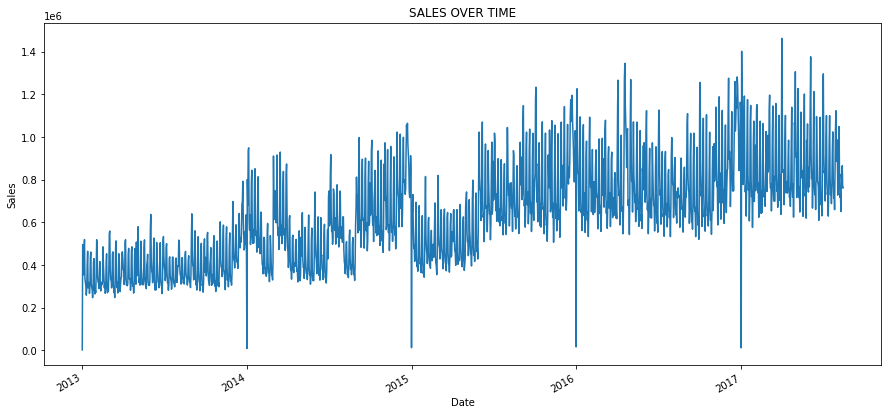

In [12]:
sales_time = df_train.groupby("date").sales.sum().reset_index()
sales_time = sales_time.set_index("date")

sales_time.plot(legend=False, figsize=(15, 7))
plt.title("SALES OVER TIME")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

There is an increase in sales over the years

# Stores Data

In [13]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
df_stores.shape

(54, 5)

In [15]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [16]:
df_stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


In [17]:
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

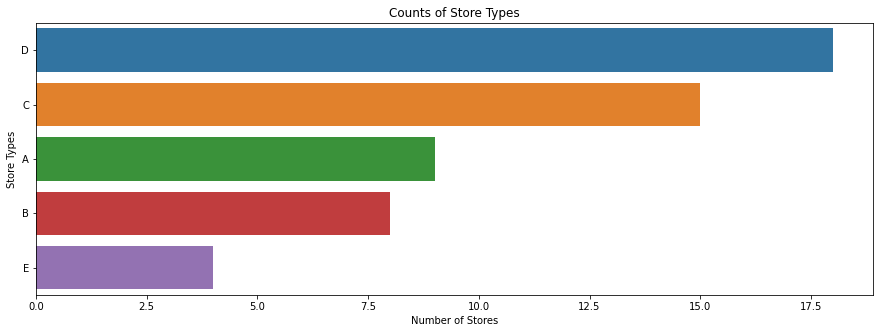

In [18]:
# Compute counts of each store type
stores = df_stores['type'].value_counts()

# Visualization
plt.figure(figsize=(15, 5))

sns.barplot(x=stores.values, y=stores.index)
plt.title('Counts of Store Types')
plt.ylabel('Store Types')
plt.xlabel("Number of Stores")
plt.show()

Store type D has the highest number of stores, while type E has the lowest number of stores

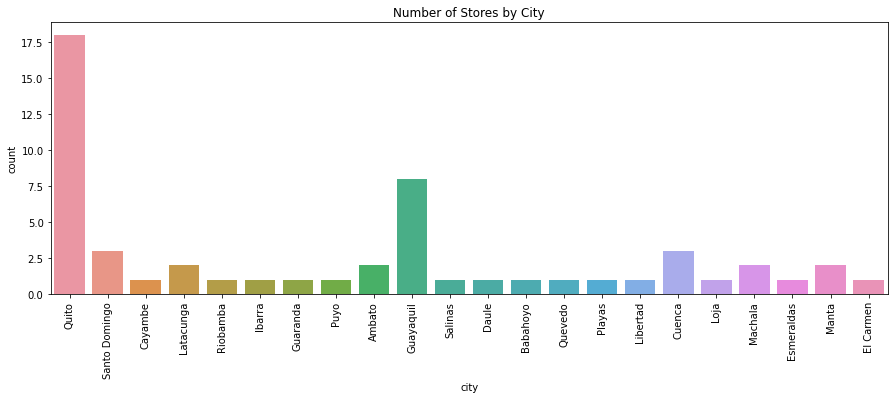

In [19]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df_stores, x='city')
plt.xticks(rotation=90)
plt.title('Number of Stores by City')
plt.show()

Quito has the highest number of stores

# Oil Data

In [20]:
data_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [21]:
data_oil.shape

(1218, 2)

In [22]:
data_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [23]:
data_oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [24]:
data_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [25]:
total_rows = len(data_oil)
null_rows = data_oil['dcoilwtico'].isnull().sum()

percentage_null = (null_rows / total_rows) * 100
print(f"Percentage of null values in 'dcoilwtico' column: {percentage_null:.2f}%")

Percentage of null values in 'dcoilwtico' column: 3.53%


In [26]:
# Use linear interpolation to impute missing values
data_oil['dcoilwtico'] = data_oil['dcoilwtico'].interpolate(method='linear')

In [27]:
# Creating a line plot using plotly.express
fig = px.line(data_oil, x='date', y='dcoilwtico', title='Oil Prices Over Time')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Oil Price')
fig.show()

This shows a decreasing trend in the prices of oil prices on the market.

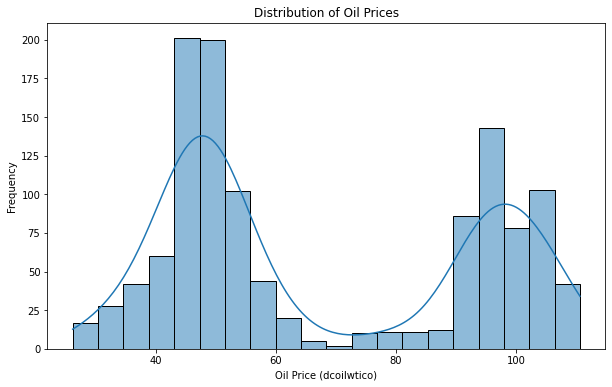

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_oil, x='dcoilwtico', bins=20, kde=True)
plt.title("Distribution of Oil Prices")
plt.xlabel("Oil Price (dcoilwtico)")
plt.ylabel("Frequency")
plt.show()

The graph shows that the price of crude oil was heavily distributed between 40 and $60 a barrel, per day. Most of the prices of crude oil per day were between this price range.

# Holiday Data

In [29]:
pd.set_option('display.max_row', None)

In [30]:
df_holidays_events.head(95) 

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [31]:
df_holidays_events.head(95) 

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [32]:
df_holidays_events.drop(columns=['description'], inplace=True)

In [33]:
df_holidays_events.shape

(350, 5)

In [34]:
df_holidays_events.describe(include='object')

,type,locale,locale_name,transferred
count,350,350,350,350
unique,6,3,24,2
top,Holiday,National,Ecuador,False
freq,221,174,174,338


In [35]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   transferred  350 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 13.8+ KB


In [36]:
df_holidays_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
transferred    0
dtype: int64

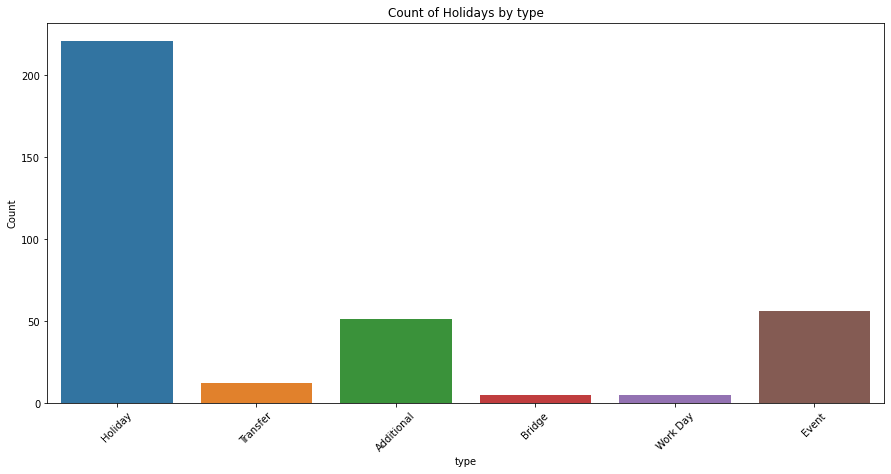

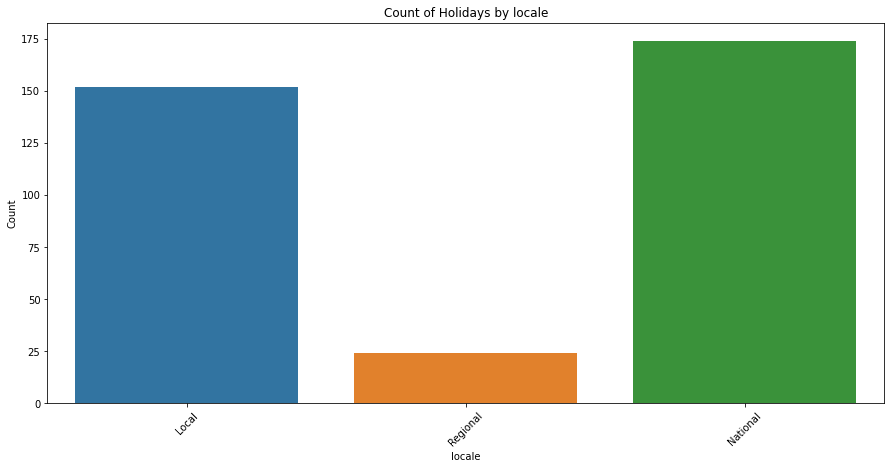

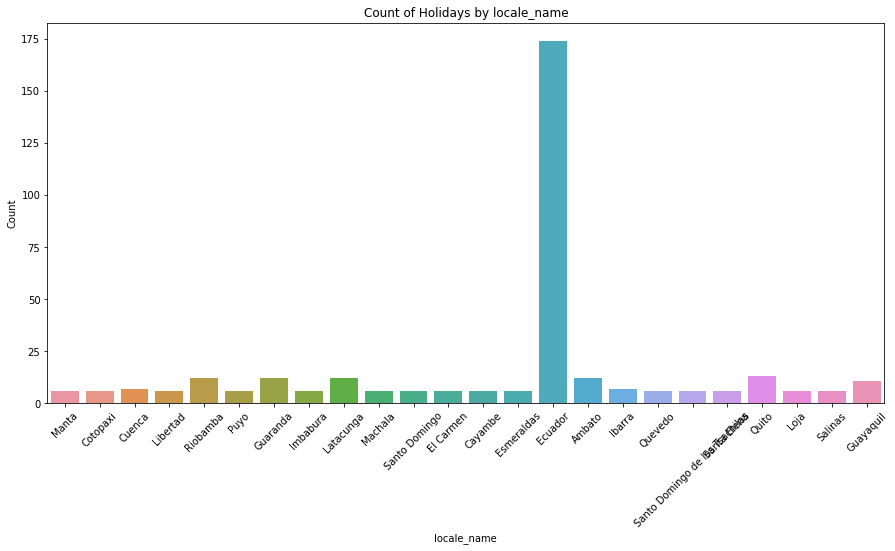

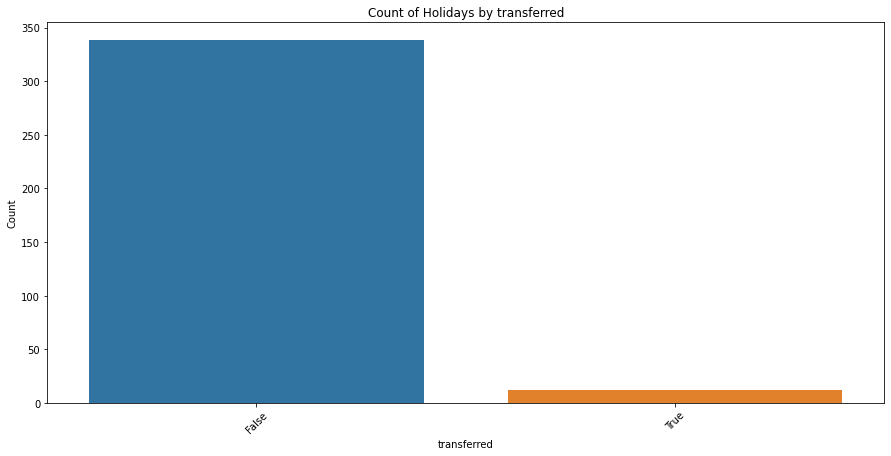

In [37]:
# Visualizing holiday count by different types
categorical_columns = ['type', 'locale', 'locale_name', 'transferred']

for column in categorical_columns:
    plt.figure(figsize=(15,7))
    sns.countplot(data=df_holidays_events, x=column)
    plt.title(f'Count of Holidays by {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  
    plt.show()

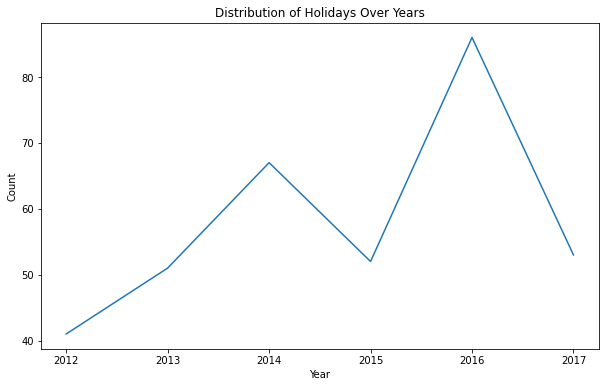

In [38]:
plt.figure(figsize=(10, 6))
df_holidays_events.groupby(df_holidays_events['date'].dt.year)['date'].count().plot(kind='line')
plt.title('Distribution of Holidays Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

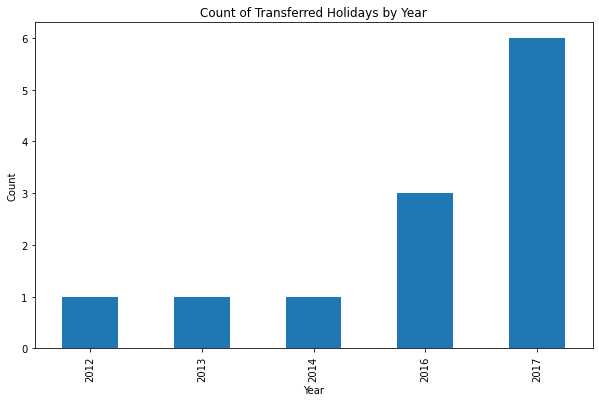

In [39]:
transferred_counts = df_holidays_events[df_holidays_events['type'] == 'Transfer'].groupby(df_holidays_events['date'].dt.year)['type'].count()

# Plot the count of transferred holidays by year
plt.figure(figsize=(10, 6))
transferred_counts.plot(kind='bar')
plt.title('Count of Transferred Holidays by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

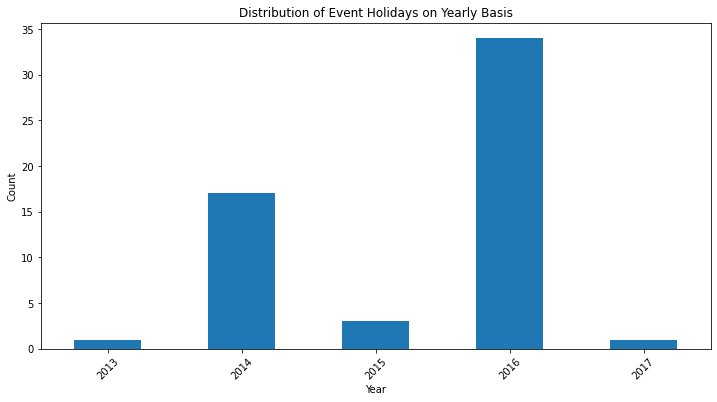

In [40]:
# Plotting distribution of event holidays on yearly basis

event_data = df_holidays_events[df_holidays_events['type'] == 'Event']

plt.figure(figsize=(12, 6))
event_data.groupby(event_data['date'].dt.year).size().plot(kind='bar')
plt.title('Distribution of Event Holidays on Yearly Basis')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Transaction Data

In [41]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [42]:
df_transactions.shape

(83488, 3)

In [43]:
df_transactions.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


In [44]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [45]:
df_transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

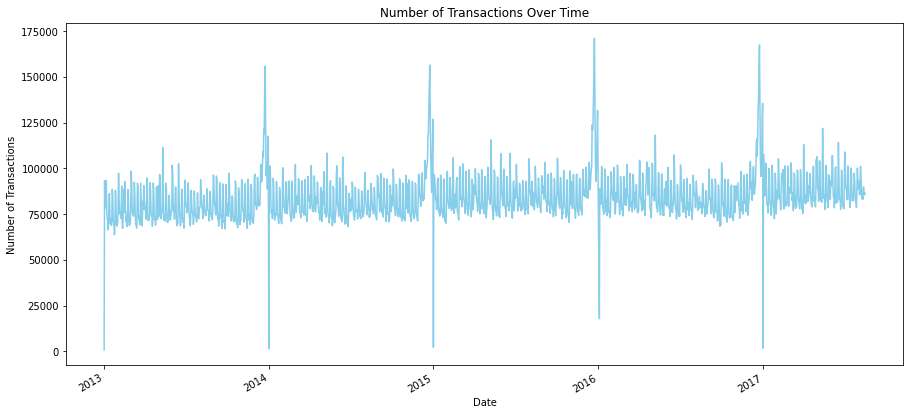

In [46]:
transactions_date = df_transactions.groupby('date').transactions.sum().reset_index()
transactions_date = transactions_date.set_index("date")

transactions_date.plot(legend=False, color="skyblue", figsize=(15, 7))
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.style.use("fivethirtyeight")
plt.show()

Transactions were stationary throughout the recorded years. With the exception, of the ends of the years where there are sharp increases in transactions showing seasonality.

# Test Data

In [47]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [48]:
df_test.shape

(28512, 5)

In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int8          
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  object        
dtypes: datetime64[ns](1), int64(1), int8(1), object(2)
memory usage: 919.0+ KB


In [50]:
df_test.describe()

,id,store_nbr
count,2.851200e+04,28512.000000
mean,3.015144e+06,27.500000
std,8.230850e+03,15.586057
min,3.000888e+06,1.000000
25%,3.008016e+06,14.000000
50%,3.015144e+06,27.500000
75%,3.022271e+06,41.000000
max,3.029399e+06,54.000000


In [51]:
df_test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

# Research / Analytical Questions

Is the train dataset complete (has all the required dates)?

Which dates have the lowest and highest sales for each year?

Did the earthquake impact sales?

Are certain groups of stores selling more products? (Cluster, city, state, type)

Are sales affected by promotions, oil prices and holidays?

Did the oil price affected Sales

How did holiday events affect Sales 

What analysis can we get from the date and its extractable features?

What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

1. Is the train dataset complete (has all the required dates)?

In [52]:
# Get the minimum and maximum dates in the DataFrame
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Create a date range for the entire period
all_dates = pd.date_range(start=min_date, end=max_date)

# Check if there are any dates missing in the DataFrame
missing_dates = all_dates.difference(df_train['date'])

if missing_dates.empty:
    print("The train dataset is complete and has all the required dates.")
else:
    print(f"The train dataset is missing the following dates:\n{missing_dates}")


The train dataset is missing the following dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


2.Which dates have the lowest and highest sales for each year?

In [53]:
# Extract year from date and add it as a new column
df_train['year'] = df_train['date'].dt.year

# Group by year and find the date with max and min sales
max_sales_dates = df_train.loc[df_train.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]
min_sales_dates = df_train.loc[df_train.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]

# Adding a column to distinguish between max and min sales
max_sales_dates['Type'] = 'Max Sales'
min_sales_dates['Type'] = 'Min Sales'

# Concatenating both dataframes and sorting by year
result_df = pd.concat([max_sales_dates, min_sales_dates], ignore_index=True).sort_values(by=['year', 'Type'], ascending=[True, False])

result_df

,year,date,sales,Type
5,2013,2013-01-01,0.000,Min Sales
0,2013,2013-11-12,46271.000,Max Sales
6,2014,2014-01-01,0.000,Min Sales
1,2014,2014-12-08,45361.000,Max Sales
7,2015,2015-01-01,0.000,Min Sales
2,2015,2015-12-14,40351.460,Max Sales
8,2016,2016-01-01,0.000,Min Sales
3,2016,2016-05-02,124717.000,Max Sales
9,2017,2017-01-01,0.000,Min Sales
4,2017,2017-04-02,38422.625,Max Sales


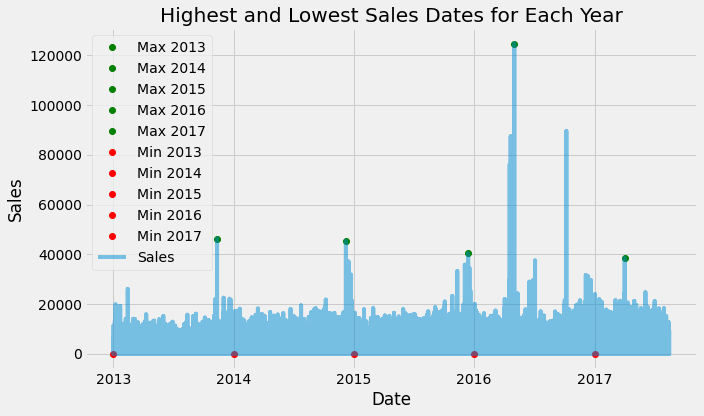

In [54]:
# Visualization
plt.figure(figsize=(10,6))

for _, row in max_sales_dates.iterrows():
    plt.plot(row['date'], row['sales'], 'go', label=f"Max {row['year']}")

for _, row in min_sales_dates.iterrows():
    plt.plot(row['date'], row['sales'], 'ro', label=f"Min {row['year']}")

plt.plot(df_train['date'], df_train['sales'], label='Sales', alpha=0.5)
plt.title("Highest and Lowest Sales Dates for Each Year")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3. Did the earthquake impact sales?

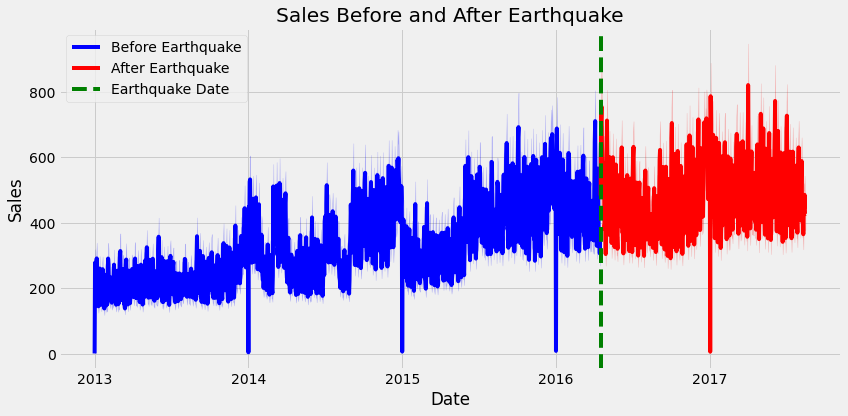

In [55]:
# Date of the earthquake
earthquake_date = "2016-04-16"
post_earthquake = df_train[df_train['date'] >= earthquake_date]
pre_earthquake = df_train[df_train['date'] < earthquake_date]

# Visualization
plt.figure(figsize=(12,6))

sns.lineplot(data=pre_earthquake, x='date', y='sales', label='Before Earthquake', color='blue')
sns.lineplot(data=post_earthquake, x='date', y='sales', label='After Earthquake', color='red')

plt.axvline(pd.to_datetime(earthquake_date), color='green', linestyle='--', label='Earthquake Date')

plt.title("Sales Before and After Earthquake")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The earthquake had no significant impact on the sales

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

In [56]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


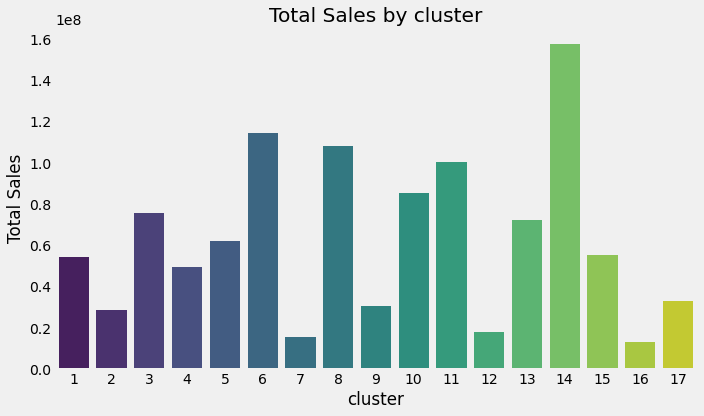

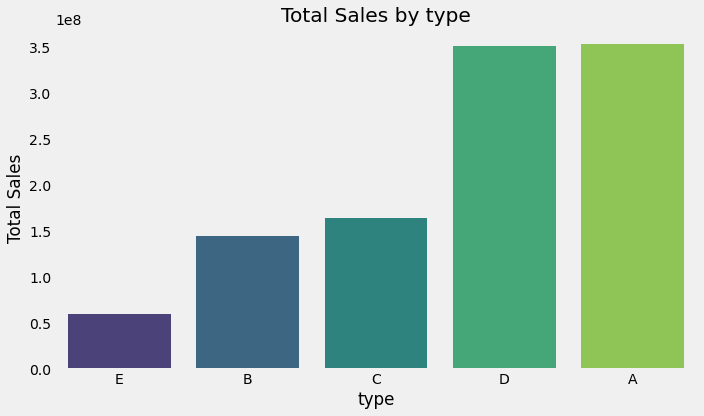

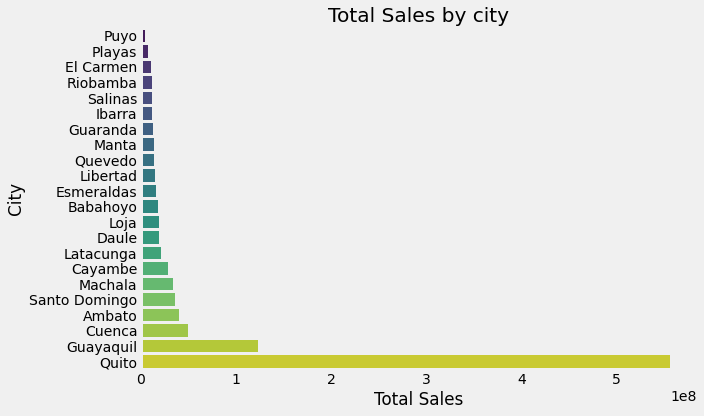

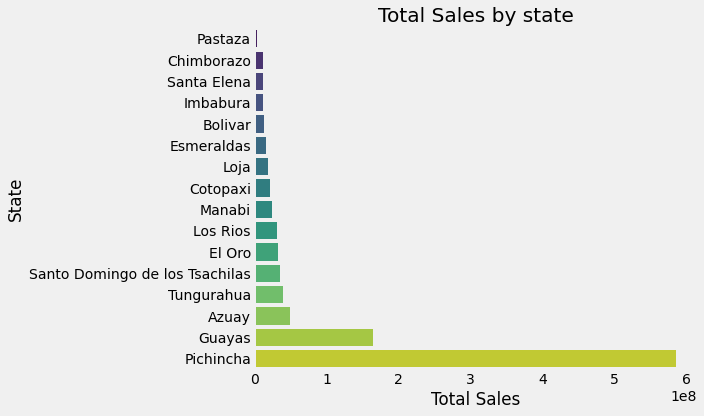

In [57]:
# Merging the data
df_merged = df_stores.merge(df_train, on='store_nbr')

# Visualizing sales by each group
for group in ['cluster', 'type']:
    plt.figure(figsize=(10, 6))
    aggregated_data = df_merged.groupby(group)['sales'].sum().sort_values()
    sns.barplot(x=aggregated_data.index, y=aggregated_data.values, palette="viridis")
    
    plt.title(f"Total Sales by {group}")
    plt.ylabel('Total Sales')
    plt.xlabel(group)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
# Visualizing sales by city and state with horizontal bar plots
for group in ['city', 'state']:
    plt.figure(figsize=(10, 6))
    aggregated_data = df_merged.groupby(group)['sales'].sum().sort_values()
    sns.barplot(y=aggregated_data.index, x=aggregated_data.values, palette="viridis", orient='h')
    
    plt.title(f"Total Sales by {group}")
    plt.xlabel('Total Sales')
    plt.ylabel(group.capitalize())
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

5. Are sales affected by promotions, oil prices and holidays?

In [58]:
# Merge sales and oil prices on 'date'
df_merged = pd.merge(df_train, data_oil, on='date', how='left')

# Merge the result with holidays on 'date'
df_merged = pd.merge(df_merged, df_holidays_events, on='date', how='left')

# Fill NaN values in the 'type', 'locale', 'locale_name', 'description', 'transferred' columns with 'NoHoliday' or appropriate placeholder
df_merged[['type', 'locale', 'locale_name']] = df_merged[['type', 'locale', 'locale_name']].fillna('NoHoliday')
df_merged['transferred'] = df_merged['transferred'].fillna(False)

df_merged.head()


,id,date,store_nbr,family,sales,onpromotion,year,dcoilwtico,type,locale,locale_name,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,NaN,Holiday,National,Ecuador,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,NaN,Holiday,National,Ecuador,False
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,NaN,Holiday,National,Ecuador,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,NaN,Holiday,National,Ecuador,False
4,4,2013-01-01,1,BOOKS,0.0,0,2013,NaN,Holiday,National,Ecuador,False


6. Did the oil price affected Sales

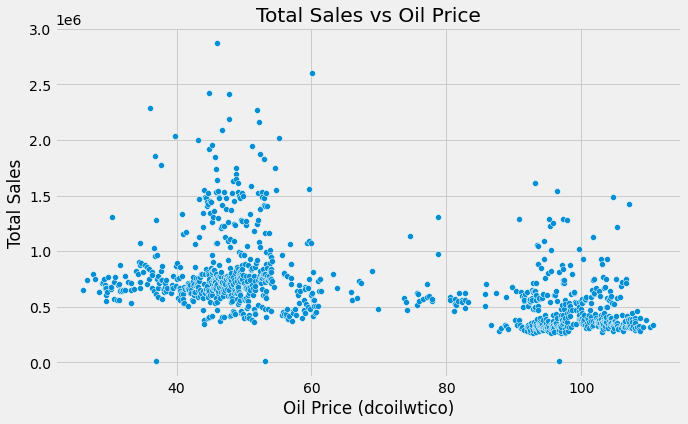

In [59]:
# Grouping the data by oil price and then calculating the total sales
oil_price_sales = df_merged.groupby('dcoilwtico')['sales'].sum()

# Creating a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=oil_price_sales.index, y=oil_price_sales.values)
plt.title('Total Sales vs Oil Price')
plt.xlabel('Oil Price (dcoilwtico)')
plt.ylabel('Total Sales')
plt.show()

7. How did holiday events affect Sales

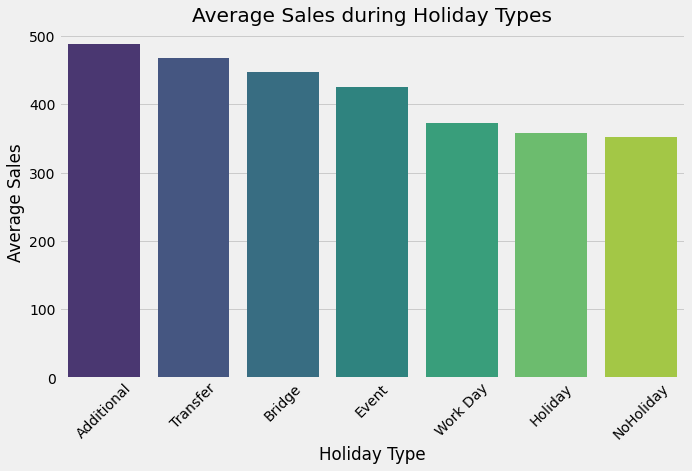

In [60]:
# Grouping the data by holiday_type and then calculating average sales
holiday_sales = df_merged.groupby('type')['sales'].mean().sort_values(ascending=False)

# Creating a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette="viridis")
plt.title('Average Sales during Holiday Types')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()


8. What analysis can we get from the date and its extractable features?

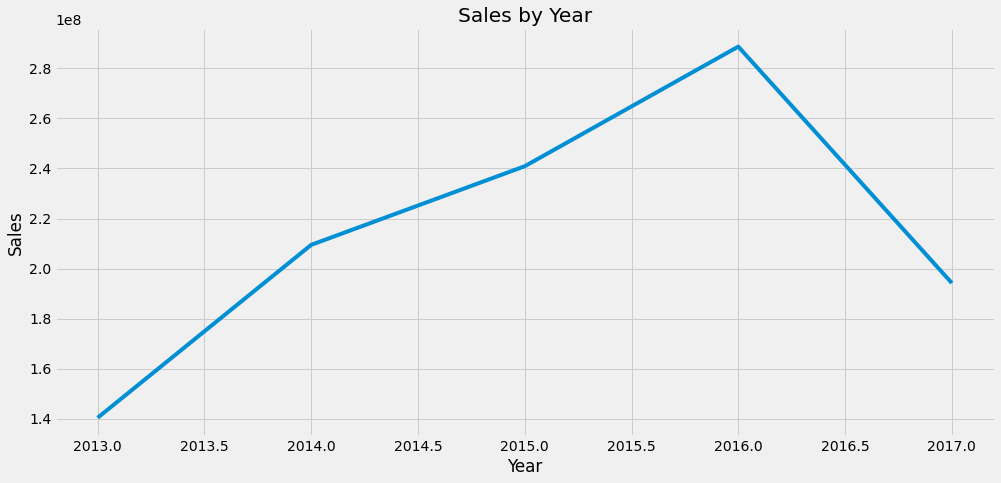

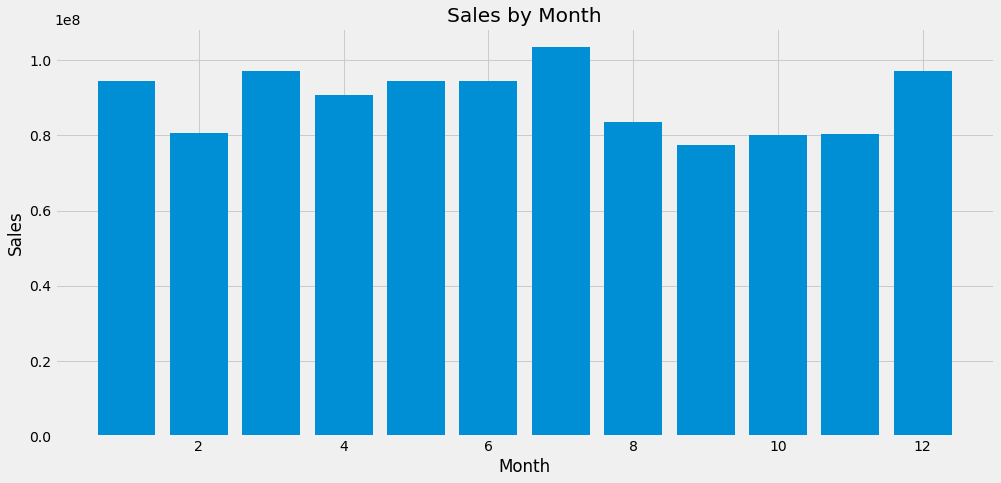

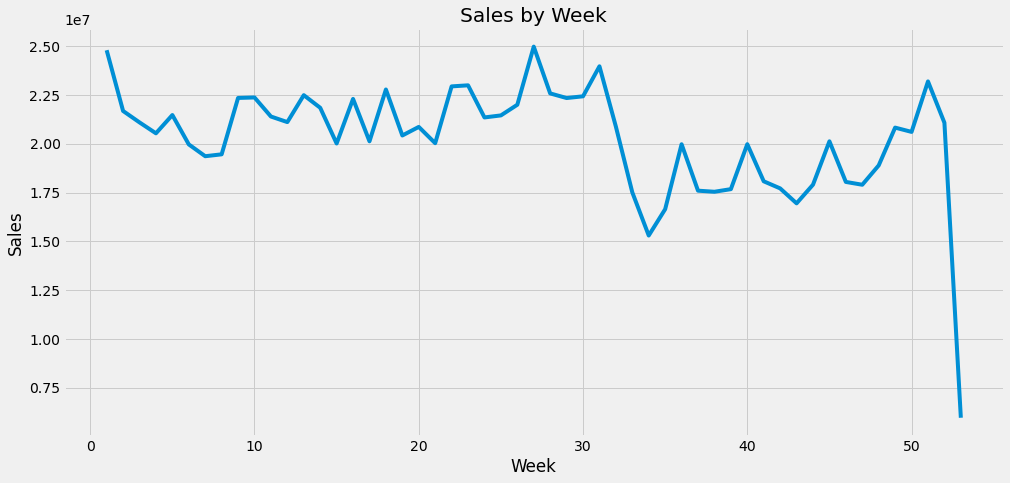

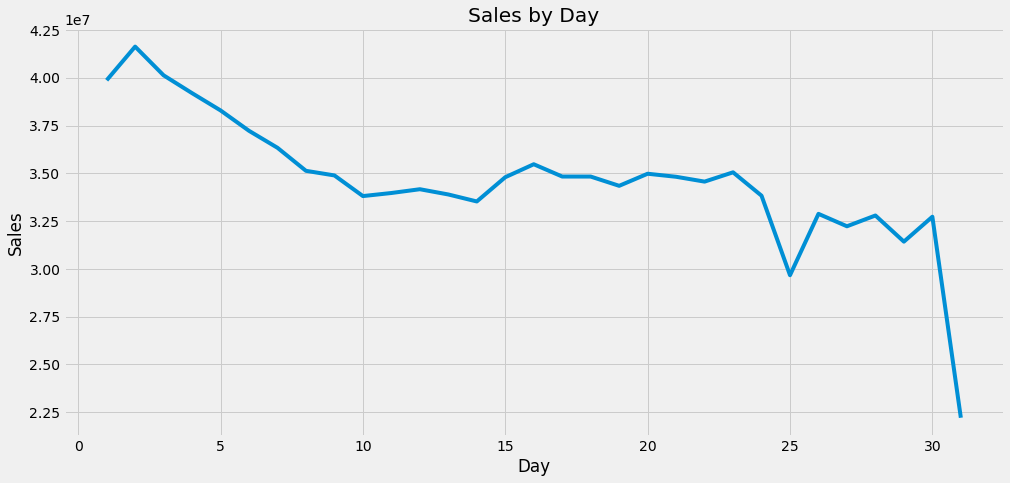

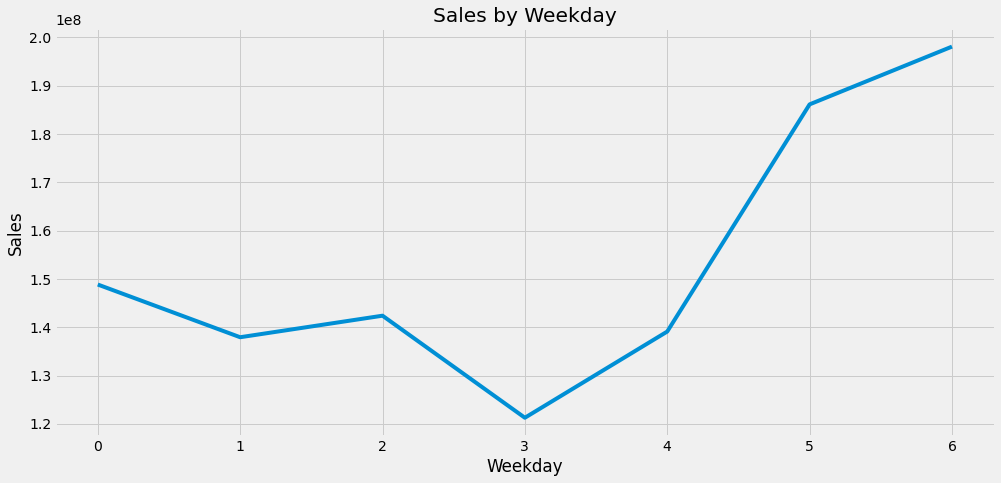

In [61]:
df_train_copy = df_train.copy()

# extract year, quarter, month, day, and weekday information from the date column
df_train_copy['year'] = df_train_copy['date'].dt.year
df_train_copy['month'] = df_train_copy['date'].dt.month
df_train_copy['week'] = df_train_copy['date'].dt.isocalendar().week
df_train_copy['day'] = df_train_copy['date'].dt.day
df_train_copy['weekday'] = df_train_copy['date'].dt.weekday

# plot the aggregated sales data by year
grouped_by_year = df_train_copy.groupby('year')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.plot(grouped_by_year.index, grouped_by_year.values)
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Sales by Year")
plt.show()

# plot the aggregated sales data by month
grouped_by_month = df_train_copy.groupby('month')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.bar(grouped_by_month.index, grouped_by_month.values)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Sales by Month")
plt.show()

# plot the aggregated sales data by week
grouped_by_week = df_train_copy.groupby('week')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.plot(grouped_by_week.index, grouped_by_week.values)
plt.xlabel("Week")
plt.ylabel("Sales")
plt.title("Sales by Week")
plt.show()

# plot the aggregated sales data by day
grouped_by_day = df_train_copy.groupby('day')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.plot(grouped_by_day.index, grouped_by_day.values)
plt.xlabel("Day")
plt.ylabel("Sales")
plt.title("Sales by Day")
plt.show()

# plot the aggregated sales data by weekday
grouped_by_weekday = df_train_copy.groupby('weekday')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.plot(grouped_by_weekday.index, grouped_by_weekday.values)
plt.xlabel("Weekday")
plt.ylabel("Sales")
plt.title("Sales by Weekday")
plt.show()

# HYPOTHESIS AND NULL HYPOTHESIS

### Null Hypothesis: Promotions do not have a positive impact on overall sales.

### Alternate Hypothesis: Promotions have a positive impact on overall sales.

In [62]:
# Extracting the 'sales' column for each group
sales_promotion = df_merged[df_merged['onpromotion'] == 1]['sales']
sales_no_promotion = df_merged[df_merged['onpromotion'] == 0]['sales']

# Performing a two-sample t-test
t_statistic, p_value = stats.ttest_ind(sales_promotion, sales_no_promotion, equal_var=False)

# Defining the significance level (alpha)
alpha = 0.05

# Comparing the p-value to the significance level
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("Promotions have a significant impact on sales.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant impact of promotions on sales.")

Fail to reject the null hypothesis.
There is no significant impact of promotions on sales.


Based on the results of the hypothesis test, it appears that there is no significant impact of promotions on sales. This means that there is insufficient evidence to conclude that promotions lead to a statistically significant increase in sales.

# Merge the Datasets

In [63]:
# Merge df_stores and df_train on 'store_nbr'
df_merged = df_train.merge(df_stores, on='store_nbr', how='left')

# Merge with data_oil on 'date'
df_merged = df_merged.merge(data_oil, on='date', how='left')

# Merge the result with df_holidays_events on 'date'
df_merged = df_merged.merge(df_holidays_events, on='date', how='left')

# Merge with df_transactions on 'date' and 'store_nbr'
#df_merged = df_merged.merge(df_transactions, on=['date', 'store_nbr'], how='left')

# Fill NaN values in the specified columns
df_merged[['type_y', 'locale', 'locale_name']] = df_merged[['type_y', 'locale', 'locale_name']].fillna('NoHoliday')
df_merged['transferred'] = df_merged['transferred'].fillna(False)

df_merged.head()


,id,date,store_nbr,family,sales,onpromotion,year,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
4,4,2013-01-01,1,BOOKS,0.0,0,2013,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False


In [64]:
#Interpolating the oil prices
df_merged['dcoilwtico'].fillna(method='ffill', inplace=True)  # Forward fill
df_merged['dcoilwtico'].fillna(method='bfill', inplace=True)  # Backfill any remaining NaNs


In [65]:
df_merged['onpromotion'] = pd.to_numeric(df_merged['onpromotion'], errors='coerce')


In [66]:
#calculating the correlation matrix for the numeric columns using the ".corr()" method
numeric_df = df_merged.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()


In [67]:
# Set 'id' column as the index
df_merged.set_index('id', inplace=True)

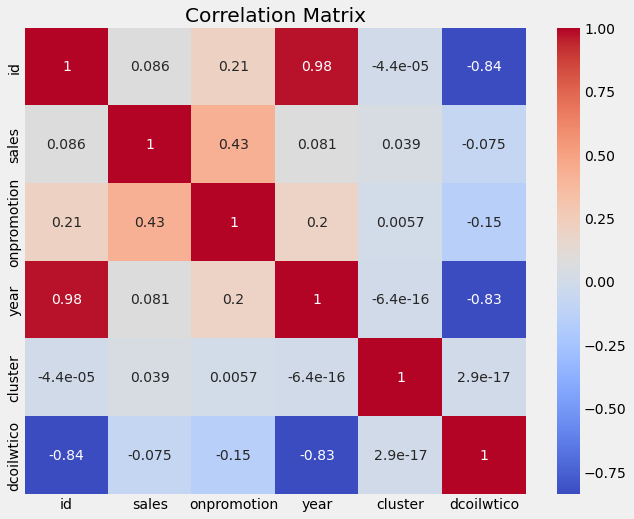

In [68]:
#generating a heatmap visualization of the correlation matrix using the Seaborn library.
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [69]:
# Columns to drop
columns_to_drop = [ 'city', 'state', 'type_x', 'dcoilwtico', 
                   'type_y', 'locale', 'locale_name', 'transferred']
# Drop the columns
df_merged = df_merged.drop(columns=columns_to_drop)



In [70]:
# Rearrange columns to make 'sales' the last column
cols = [col for col in df_merged.columns if col != 'sales'] + ['sales']
df_merged = df_merged[cols]

In [71]:
'''
# Save to CSV
df_merged.to_csv("df_merged.csv")
'''

'\n# Save to CSV\ndf_merged.to_csv("df_merged.csv")\n'

In [72]:
###df_merged = pd.read_csv("df_merged.csv")

In [73]:
# Aggregating data #'family'

df_family_aggregated = df_merged.groupby(['date', 'family']).agg({'sales': 'sum', 'onpromotion': 'sum'  # This can be a mean (indicating the proportion of items on promotion) or sum.    
}).reset_index()


why are we aggregating you ask?

When testing properties such as presence of a unit root, what matters is the time span, not the frequency at which the data is sampled. Unless the sample is too small for asymptotic inference, that is.

http://davegiles.blogspot.no/2014/05/unit-root-testing-sample-size-vs-sample.html
http://davegiles.blogspot.no/2014/09/the-econometrics-of-temporal.html#more
https://johnhcochrane.blogspot.com/2015/04/unit-roots-redux.html#more



In [74]:
df_family_aggregated.isnull().sum()

date           0
family         0
sales          0
onpromotion    0
dtype: int64

In [75]:
print(df_family_aggregated.dtypes)

date           datetime64[ns]
family                 object
sales                 float64
onpromotion             int64
dtype: object





<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> Feature Engineering</center></h1> 


Sales can vary significantly depending on the day of the week. For example, retailers might observe more sales on weekends as compared to weekdays. By including the day of the week as a predictor, the model can capture such weekly patterns.

Lagged variables help the model understand temporal dependencies. If sales today depend on sales from the previous day or the same day from the previous week, these lagged variables can capture that relationship.

Rolling statistics can smooth out short-term fluctuations and highlight longer-term trends or cycles in the data. This helps in capturing seasonality or patterns that recur over fixed periods.

To improve the prediction of sales, the dataset has been enhanced by:

Incorporating the day of the week to account for weekly sales patterns.

Adding lagged sales variables to capture short-term dependencies and potential weekly patterns.

Introducing rolling statistics, specifically a 7-day rolling mean, to smooth out short-term variations and emphasize longer-term trends.

In [76]:
# 1. Day of the week (0 = Monday, 6 = Sunday)
df_family_aggregated['day_of_week'] = df_family_aggregated['date'].dt.dayofweek

# 2. Lagged variables
# Here I'm creating a 1-day lag for sales. 
df_family_aggregated['lag_1'] = df_family_aggregated['sales'].shift(1)

# df_family_aggregated['lag_7'] = df_family_aggregated['sales'].shift(7)  # 1-week lag

# 3. Rolling statistics
window_size = 7  # 7-day window, you can adjust this based on your data's frequency and need
df_family_aggregated['rolling_mean'] = df_family_aggregated['sales'].rolling(window=window_size).mean()


In [77]:
df_family_aggregated.isnull().sum()

date            0
family          0
sales           0
onpromotion     0
day_of_week     0
lag_1           1
rolling_mean    6
dtype: int64

In [78]:
# Drop the rows with NaN values that were introduced due to lag and rolling stats calculations
df_family_aggregated.dropna(inplace=True)

In [79]:
print(df_family_aggregated.dtypes)

date            datetime64[ns]
family                  object
sales                  float64
onpromotion              int64
day_of_week              int64
lag_1                  float64
rolling_mean           float64
dtype: object


## Checking if the new Variables added are statistically significant in predicting Sales

In [80]:
# Defining our independent variables (X) and dependent variable (y)
X = df_family_aggregated[['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df_family_aggregated['sales']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 1.102e+04
Date:                Sun, 17 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:30:25   Log-Likelihood:            -6.6189e+05
No. Observations:               55566   AIC:                         1.324e+06
Df Residuals:                   55561   BIC:                         1.324e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3154.2239    311.309    -10.132   

const: The p-value is practically 0 (significantly less than 0.05). This means that the intercept (const) is statistically significant, and its estimated value is different from zero in the population.

onpromotion: The p-value is also essentially 0. This indicates that the coefficient for the onpromotion variable is statistically significant, implying that promotions have a significant effect on sales.

day_of_week: The p-value here is less than 0.05, suggesting that the day_of_week coefficient is statistically significant. Therefore, the day of the week has a significant influence on sales.

lag_1: With a p-value that's virtually 0, the lag_1 coefficient is statistically significant. This implies that the sales value of the previous day (or period) significantly affects the current sales.

rolling_mean: The p-value for this variable is again essentially 0. It suggests that the rolling mean is a statistically significant predictor for sales in the model.

## Performing the VIF test to check for multicollinearity

In [81]:
# Check VIF scores for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

        feature       VIF
0         const  4.142202
1   onpromotion  1.152698
2   day_of_week  1.018103
3         lag_1  1.199089
4  rolling_mean  1.360954


VIF = 1: No multicollinearity.

1 < VIF < 5: Moderately correlated. In many fields, a VIF below 5 is considered acceptable.

VIF >= 5: Highly correlated. A VIF above 5 is typically considered to indicate high multicollinearity.

const: VIF of 4.142 suggests that the intercept is moderately correlated with other predictors. This is not typically a concern since it's the constant.

onpromotion: A VIF of 1.1527 indicates little to no multicollinearity.

day_of_week: With a VIF close to 1 (1.0181), this predictor is not showing multicollinearity.

lag_1: A VIF of 1.1991 also suggests very minimal multicollinearity.

rolling_mean: A VIF of 1.3610 indicates little multicollinearity but slightly more than the other predictors (excluding the constant).




<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> Visualizing the Sales Column</center></h1> 


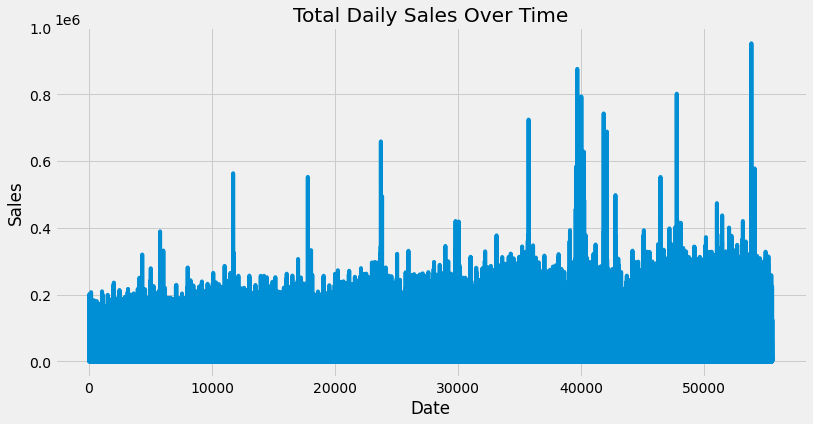

In [82]:

# 1. Visualization
plt.figure(figsize=(12, 6))
df_family_aggregated['sales'].plot(title='Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()



The Autocorrelation Function (ACF) is a tool that provides information about the linear relationship between values of a time series separated by various time lags. In simpler terms, it tells you how correlated a time series is with itself at different lagged values.
A stationary time series will have an ACF that drops to zero relatively quickly, while the ACF of non-stationary data decreases slowly. Also, for a non-stationary series, the ACF will often have values that remain significant over several lags, which is indicative of a strong time-dependent structure.

## Plotting the ACF

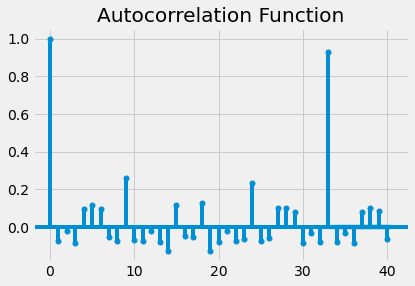

In [83]:


# ACF Plot
plot_acf(df_family_aggregated['sales'], lags=40)
plt.title('Autocorrelation Function')
plt.show()

A stationary time series will have an ACF that decays to zero relatively quickly. This means that the correlation between the current value of the time series and its past values decreases as the lag increases. The ACF decays to zero relatively quickly meaning it is stationary but we have to do a formal test to confirm this 




<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> Augmented Dickey-Fuller (ADF)</center></h1> 

The Augmented Dickey-Fuller (ADF) test is a formal statistical test for stationarity. Specifically, it's used to determine the presence of a unit root in a time series, which would suggest that the time series is non-stationary. 

In [84]:

# ADF Test
result = adfuller(df_family_aggregated['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")  


ADF Statistic: -18.40867701372848
p-value: 2.18611072456115e-30
Critical Values: {'1%': -3.4304678179375836, '5%': -2.8615920732225892, '10%': -2.566797716834345}
The time series is stationary.



<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> DATA PREPROCESSING</center></h1> 

In [85]:
# One-hot encoding for family column
df_family_dummies = pd.get_dummies(df_family_aggregated['family'], drop_first=True, prefix='family')
df_family_aggregated = pd.concat([df_family_aggregated, df_family_dummies], axis=1)
df_family_aggregated.drop('family', axis=1, inplace=True)

In [86]:
# Features to scale
columns_to_scale = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean', 'sales'] + list(df_family_dummies.columns)#'is_holiday'

scaler = MinMaxScaler()
df_family_aggregated[columns_to_scale] = scaler.fit_transform(df_family_aggregated[columns_to_scale])


In [87]:
df_family_aggregated = df_family_aggregated.sort_values('date')


In [88]:
train_size = int(0.8 * len(df_family_aggregated))
train_data = df_family_aggregated[:train_size]
test_data = df_family_aggregated[train_size:]

X_train = train_data.drop(columns=['sales', 'date'])
y_train = train_data['sales']
X_test = test_data.drop(columns=['sales', 'date'])
y_test = test_data['sales']



<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> Model Selection</center></h1> 

ARIMA: Effective for data with no seasonality. Works well when a series is stationary or can be made stationary through differencing (hence the "Integrated" part in ARIMA).

SARIMA: An extension of ARIMA to handle seasonality in the data.

Exponential Smoothing: Useful for data with a trend or seasonality. There are variations like Holt (for trend) and Holt-Winters (for both trend and seasonality).

LSTM: A type of recurrent neural network. Can capture long-term dependencies and complex patterns in the data. Typically requires more data and more computational resource

XGB Boost


<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> ACF AND PACF</center></h1> 

The Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) plots are fundamental diagnostic tools. They help us understand the underlying characteristics of a time series dataset, and more specifically, they are typically used when modeling the data using Autoregressive Integrated Moving Average (ARIMA) models or its variants.

<Figure size 720x360 with 0 Axes>

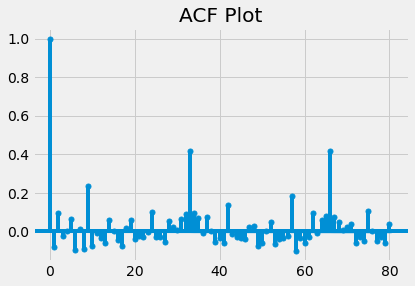

In [89]:
# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(df_family_aggregated['sales'], lags=80)  # you can adjust the lags as per your data's requirements
plt.title('ACF Plot')
plt.show()

<Figure size 720x360 with 0 Axes>

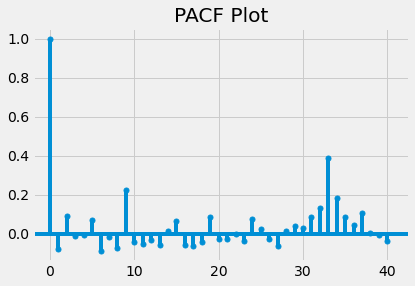

In [90]:
# Plot PACF
plt.figure(figsize=(10, 5))
plot_pacf(df_family_aggregated['sales'], lags=40)  # again, adjust lags as necessary
plt.title('PACF Plot')
plt.show()


The appropriate ARIMA model for our dataset is ARIMA(1,0,0). This is because only the first lag exhibits statistical significance, suggesting an autoregressive order of 1. Additionally, there's no indication of a moving average component, and differencing of the target variable was not required.


<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> FITTING MODELS</center></h1> 

In [91]:
# storing the exogenous variables

exog_features = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']


In [92]:
# RMSLE Definition
def rmsle(predicted, actual):
    return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))


In [93]:
# Suppress the ValueWarning warnings
warnings.simplefilter(action='ignore', category=ValueWarning)


/home/florence/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



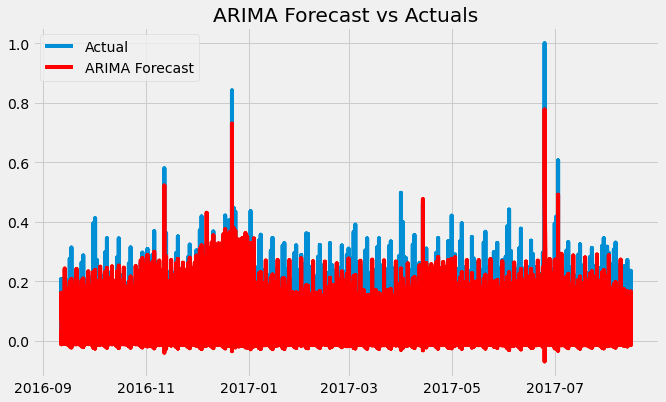

In [94]:

# Fitting Arima Model
model_arima = sm.tsa.SARIMAX(y_train, exog=X_train[exog_features], order=(1,0,0))
results_arima = model_arima.fit(disp=False)
forecast_arima = results_arima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test[exog_features])

# Visualization
plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual')
plt.plot(test_data['date'], forecast_arima, color='red', label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actuals')
plt.show()

mse_arima = mean_squared_error(y_test, forecast_arima)
rmse_arima = np.sqrt(mse_arima)
rmsle_arima = rmsle(forecast_arima, y_test)


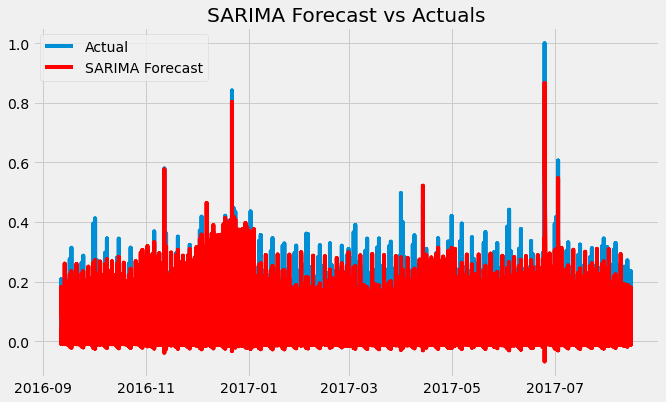

In [95]:
# Fitting sarima Model

model_sarima = sm.tsa.SARIMAX(y_train, exog=X_train[exog_features], order=(1,1,0), seasonal_order=(1,0,0,12))
results_sarima = model_sarima.fit(disp=False)
forecast_sarima = results_sarima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test[exog_features])

#Visualization
plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual')
plt.plot(test_data['date'], forecast_sarima, color='red', label='SARIMA Forecast')
plt.legend()
plt.title('SARIMA Forecast vs Actuals')
plt.show()

mse_sarima = mean_squared_error(y_test, forecast_sarima)
rmse_sarima = np.sqrt(mse_sarima)
rmsle_sarima = rmsle(forecast_sarima, y_test)



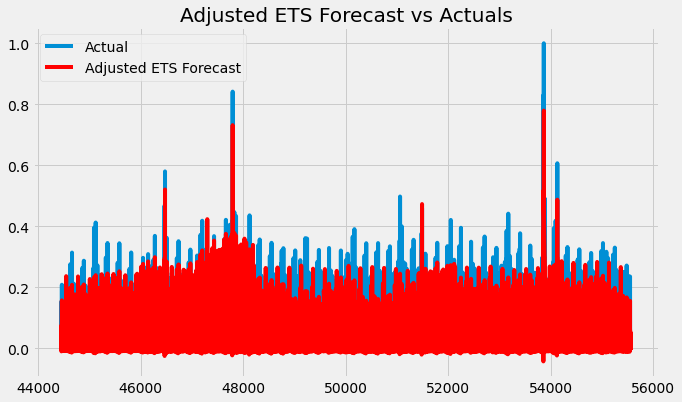

In [96]:
# 1. Fit ETS Model and Make Initial Forecasts
model_ets = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12)
results_ets = model_ets.fit()
initial_forecast = results_ets.forecast(steps=len(y_test))

# 2. Prepare Adjusted Exogenous Data for Linear Regression

# Using the initial forecast and exog features to predict y_test.
X_adjust_train = pd.concat([y_train.shift(-1).dropna().rename("forecast"), X_train[exog_features].iloc[1:, :]], axis=1)
X_adjust_test = pd.concat([pd.Series(initial_forecast, index=y_test.index).rename("forecast"), X_test[exog_features]], axis=1)

# Remove rows with NaN values
X_adjust_train = X_adjust_train.dropna()
y_adjust_train = y_train.loc[X_adjust_train.index]

X_adjust_test = X_adjust_test.dropna()
y_adjust_test = y_test.loc[X_adjust_test.index]

# Convert all feature names to strings
X_adjust_train.columns = X_adjust_train.columns.astype(str)
X_adjust_test.columns = X_adjust_test.columns.astype(str)

# 3. Fit the Linear Regression Model

lr = LinearRegression()
lr.fit(X_adjust_train, y_adjust_train)
forecast_ets = lr.predict(X_adjust_test)

# 4. Visualization
plt.figure(figsize=(10,6))
plt.plot(y_adjust_test.index, y_adjust_test, label='Actual')
plt.plot(y_adjust_test.index, forecast_ets, color='red', label='Adjusted ETS Forecast')
plt.legend()
plt.title('Adjusted ETS Forecast vs Actuals')
plt.show()


# 5. Performance Metrics
mse_ets = mean_squared_error(y_adjust_test, forecast_ets)
rmse_ets = np.sqrt(mse_ets)
rmsle_ets = rmsle(forecast_ets, y_adjust_test)





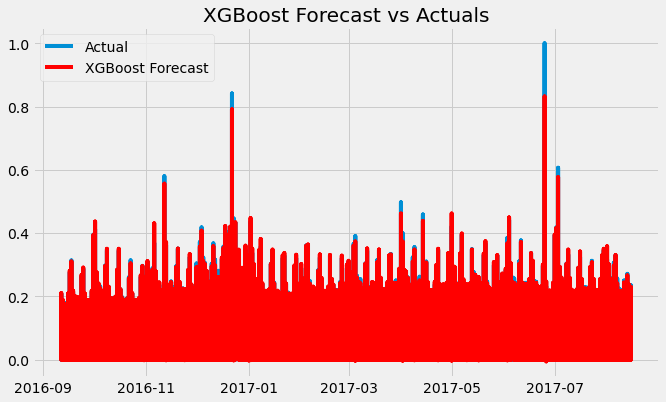

In [97]:
#Fitting XGB Boost Regressor
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror')
model_xgb.fit(X_train, y_train)
forecast_xgb = model_xgb.predict(X_test)

# Visualization
plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual')
plt.plot(test_data['date'], forecast_xgb, color='red', label='XGBoost Forecast')
plt.legend()
plt.title('XGBoost Forecast vs Actuals')
plt.show()

mse_xgb = mean_squared_error(y_test, forecast_xgb)
rmse_xgb = np.sqrt(mse_xgb)
rmsle_xgb = rmsle(forecast_xgb, y_test)



Epoch 1/50
618/618 - 6s - loss: 0.0014 - val_loss: 0.0015
Epoch 2/50
618/618 - 2s - loss: 0.0013 - val_loss: 0.0015
Epoch 3/50
618/618 - 2s - loss: 0.0013 - val_loss: 0.0015
Epoch 4/50
618/618 - 2s - loss: 0.0013 - val_loss: 0.0015
Epoch 5/50
618/618 - 2s - loss: 0.0013 - val_loss: 0.0015
Epoch 6/50
618/618 - 2s - loss: 0.0013 - val_loss: 0.0015
Epoch 7/50
618/618 - 2s - loss: 0.0013 - val_loss: 0.0014
Epoch 8/50
618/618 - 2s - loss: 0.0013 - val_loss: 0.0014
Epoch 9/50
618/618 - 2s - loss: 0.0013 - val_loss: 0.0014
Epoch 10/50
618/618 - 2s - loss: 0.0012 - val_loss: 0.0014
Epoch 11/50
618/618 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch 12/50
618/618 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch 13/50
618/618 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch 14/50
618/618 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch 15/50
618/618 - 2s - loss: 0.0011 - val_loss: 0.0013
Epoch 16/50
618/618 - 2s - loss: 0.0011 - val_loss: 0.0013
Epoch 17/50
618/618 - 2s - loss: 0.0011 - val_loss: 0.0013
Epoch 

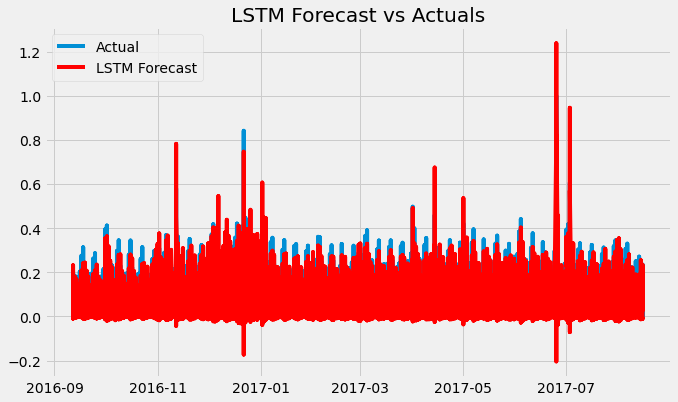

In [98]:
X_train_values = X_train[exog_features].values.reshape(X_train.shape[0], 1, len(exog_features))
X_test_values = X_test[exog_features].values.reshape(X_test.shape[0], 1, len(exog_features))

# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_values.shape[1], X_train_values.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')

model_lstm.fit(X_train_values, y_train, epochs=50, batch_size=72, validation_data=(X_test_values, y_test), verbose=2, shuffle=False)

forecast_lstm = model_lstm.predict(X_test_values).flatten()

plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual')
plt.plot(test_data['date'], forecast_lstm, color='red', label='LSTM Forecast')
plt.legend()
plt.title('LSTM Forecast vs Actuals')
plt.show()

mse_lstm = mean_squared_error(y_test, forecast_lstm)
rmse_lstm = np.sqrt(mse_lstm)
rmsle_lstm = rmsle(forecast_lstm, y_test)


In [99]:
# Create a dictionary of RMSE and MSE for each model
data = {
    'Model': ['ARIMA', 'SARIMA', 'ExponentialSmoothing', 'XGBoost', 'LSTM'],
    'RMSE': [rmse_arima, rmse_sarima, rmse_ets, rmse_xgb, rmse_lstm],
    'MSE': [mse_arima, mse_sarima, mse_ets, mse_xgb, mse_lstm],
    'RMSLE': [rmsle_arima, rmsle_sarima, rmsle_ets, rmsle_xgb, rmsle_lstm]
}

range_of_y_test = y_test.max() - y_test.min()

# Convert dictionary to DataFrame
score_df = pd.DataFrame(data)

percentage_rmse = score_df['RMSE'] * 100
percentage_mse = score_df['MSE'] * 100

score_df['RMSE (%)'] = percentage_rmse
score_df['MSE (%)'] = percentage_mse

# Display the scores table
print(score_df) 


                  Model      RMSE       MSE     RMSLE  RMSE (%)   MSE (%)
0                 ARIMA  0.041737  0.001742  0.079094  4.173722  0.174200
1                SARIMA  0.047227  0.002230  0.084381  4.722750  0.223044
2  ExponentialSmoothing  0.041575  0.001728  0.037704  4.157463  0.172845
3               XGBoost  0.006873  0.000047  0.005539  0.687252  0.004723
4                  LSTM  0.038148  0.001455  0.033689  3.814842  0.145530



<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> ADVANCED MODEL EVALUATION</center></h1> 

In [100]:
# TIme series splitting for cross Validation
tscv = TimeSeriesSplit(n_splits=5)


In [101]:
# Cross Validating ARIMA Model
mse_scores_arima = []
rmsle_scores_arima = []  # List to collect RMSLE scores

for train_index, test_index in tscv.split(y_train):
    train, test = y_train.iloc[train_index], y_train.iloc[test_index]
    exog_train, exog_test = X_train.iloc[train_index], X_train.iloc[test_index]
    
    model_arima = sm.tsa.SARIMAX(train, exog=exog_train[exog_features], order=(1,0,0))
    results_arima = model_arima.fit(disp=False)
    forecast_arima = results_arima.predict(start=len(train), end=len(train) + len(test) - 1, exog=exog_test[exog_features])
    
    mse_arima = mean_squared_error(test, forecast_arima)
    mse_scores_arima.append(mse_arima)

    # Computing RMSLE using your custom function
    rmsle_value = rmsle(forecast_arima, test)
    rmsle_scores_arima.append(rmsle_value)


In [102]:
mse_scores_sarima = []
rmsle_scores_sarima = []  # List to collect RMSLE scores

for train_index, test_index in tscv.split(y_train):
    train, test = y_train.iloc[train_index], y_train.iloc[test_index]
    exog_train, exog_test = X_train.iloc[train_index], X_train.iloc[test_index]
    
    model_sarima = sm.tsa.SARIMAX(train, exog=exog_train[exog_features], order=(1,1,0), seasonal_order=(1,0,0,12))
    results_sarima = model_sarima.fit(disp=False)
    forecast_sarima = results_sarima.predict(start=len(train), end=len(train) + len(test) - 1, exog=exog_test[exog_features])
    
    mse_sarima = mean_squared_error(test, forecast_sarima)
    mse_scores_sarima.append(mse_sarima)

    # Computing RMSLE using your custom function
    rmsle_value = rmsle(forecast_sarima, test)
    rmsle_scores_sarima.append(rmsle_value)

In [103]:


mse_scores_ets = []
rmsle_scores_ets = []  # List to collect RMSLE scores

for train_index, test_index in tscv.split(y_train):
    train, test = y_train.iloc[train_index], y_train.iloc[test_index]
    exog_train, exog_test = X_train.iloc[train_index], X_train.iloc[test_index]
    
    model_ets = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12)
    results_ets = model_ets.fit()
    initial_forecast = results_ets.forecast(steps=len(test))

    X_adjust_train = pd.concat([train.shift(-1).dropna().rename("forecast"), exog_train[exog_features].iloc[1:, :]], axis=1)
    X_adjust_test = pd.concat([pd.Series(initial_forecast, index=test.index).rename("forecast"), exog_test[exog_features]], axis=1)
    
    # Remove rows with NaN values
    X_adjust_train = X_adjust_train.dropna()
    y_adjust_train = train.loc[X_adjust_train.index]

    X_adjust_test = X_adjust_test.dropna()
    y_adjust_test = test.loc[X_adjust_test.index]

    # Convert all feature names to strings
    X_adjust_train.columns = X_adjust_train.columns.astype(str)
    X_adjust_test.columns = X_adjust_test.columns.astype(str)

    # Fit the Linear Regression Model
    lr = LinearRegression()
    lr.fit(X_adjust_train, y_adjust_train)
    forecast_ets = lr.predict(X_adjust_test)
    
    mse_ets = mean_squared_error(y_adjust_test, forecast_ets)
    mse_scores_ets.append(mse_ets)

    # Computing RMSLE using your custom function
    rmsle_value = rmsle(forecast_ets, y_adjust_test)
    rmsle_scores_ets.append(rmsle_value)


In [104]:
mse_scores_xgb = []
rmsle_scores_xgb = []  # List to collect RMSLE scores

for train_index, test_index in tscv.split(y_train):
    train, test = y_train.iloc[train_index], y_train.iloc[test_index]
    exog_train, exog_test = X_train.iloc[train_index], X_train.iloc[test_index]
    
    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror')
    model_xgb.fit(exog_train, train)
    forecast_xgb = model_xgb.predict(exog_test)
    
    mse_xgb = mean_squared_error(test, forecast_xgb)
    mse_scores_xgb.append(mse_xgb)

    # Computing RMSLE using your custom function
    rmsle_value = rmsle(forecast_xgb, test)
    rmsle_scores_xgb.append(rmsle_value)

In [105]:
#Cross Validation of LSTM Model 
rmsle_scores = []

for train_index, test_index in tscv.split(X_train_values):
    
    X_train_cv, X_test_cv = X_train_values[train_index], X_train_values[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, input_shape=(X_train_cv.shape[1], X_train_cv.shape[2])))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mse', optimizer='adam')
    model_lstm.fit(X_train_cv, y_train_cv, epochs=50, batch_size=72, validation_data=(X_test_cv, y_test_cv), verbose=2, shuffle=False)
    
    forecast_lstm = model_lstm.predict(X_test_cv).flatten()
    score = rmsle(forecast_lstm, y_test_cv)
    rmsle_scores.append(score)
    print(f'RMSLE Score for split {len(rmsle_scores)}: {score}')

print(f'Average RMSLE Score: {np.mean(rmsle_scores)}')


Epoch 1/50
103/103 - 3s - loss: 0.0011 - val_loss: 0.0013
Epoch 2/50
103/103 - 0s - loss: 8.0671e-04 - val_loss: 0.0011
Epoch 3/50
103/103 - 0s - loss: 7.6183e-04 - val_loss: 0.0011
Epoch 4/50
103/103 - 0s - loss: 7.5524e-04 - val_loss: 0.0011
Epoch 5/50
103/103 - 0s - loss: 7.5460e-04 - val_loss: 0.0011
Epoch 6/50
103/103 - 0s - loss: 7.5427e-04 - val_loss: 0.0011
Epoch 7/50
103/103 - 0s - loss: 7.5393e-04 - val_loss: 0.0011
Epoch 8/50
103/103 - 0s - loss: 7.5357e-04 - val_loss: 0.0011
Epoch 9/50
103/103 - 0s - loss: 7.5318e-04 - val_loss: 0.0011
Epoch 10/50
103/103 - 0s - loss: 7.5278e-04 - val_loss: 0.0011
Epoch 11/50
103/103 - 0s - loss: 7.5237e-04 - val_loss: 0.0011
Epoch 12/50
103/103 - 0s - loss: 7.5195e-04 - val_loss: 0.0011
Epoch 13/50
103/103 - 0s - loss: 7.5152e-04 - val_loss: 0.0011
Epoch 14/50
103/103 - 0s - loss: 7.5108e-04 - val_loss: 0.0011
Epoch 15/50
103/103 - 0s - loss: 7.5062e-04 - val_loss: 0.0011
Epoch 16/50
103/103 - 0s - loss: 7.5014e-04 - val_loss: 0.0011
Epoch

In [106]:
# Create a DataFrame for RMSLE
df_rmsle_scores = pd.DataFrame({
    'ARIMA': rmsle_scores_arima,
    'SARIMA': rmsle_scores_sarima,
    'ETS': rmsle_scores_ets,
    'XGBoost': rmsle_scores_xgb,
    'LSTM' : rmsle_scores  
})

# Compute the average RMSLE across all folds for each model
avg_rmsle = df_rmsle_scores.mean().sort_values(ascending=True)  # Lower RMSLE values are better, hence sort in ascending

print(avg_rmsle)

XGBoost    0.007436
LSTM       0.034325
ETS        0.035308
ARIMA      0.051475
SARIMA     0.054317
dtype: float64


XGBoost: With an RMSLE of 0.007496, this model demonstrates the best performance among all the models tested. It has the closest predictions to the actual data, with the error being the smallest.

LSTM: The LSTM model, a type of recurrent neural network, yielded an RMSLE of 0.034217. While it performs reasonably well, it's not as precise as the XGBoost model.

ETS: The Exponential Smoothing model has an RMSLE of 0.035308, which is close to the LSTM model's performance but slightly worse. ETS is a time series forecasting method that captures different time series components like trend and seasonality.

ARIMA: The AutoRegressive Integrated Moving Average model produced an RMSLE of 0.051475. ARIMA is a classical method in time series forecasting that combines autoregressive, differencing, and moving average components.

SARIMA: The Seasonal ARIMA, which extends ARIMA by adding a seasonal component, has the highest RMSLE of 0.054316. This suggests it's the least accurate among the models tested on this dataset.

The SARIMA model was dropped from consideration due to its high RMSLE score of 0.054316. This score indicates that, among the models tested, SARIMA had the least accurate predictions, making other models, especially XGBoost with its significantly lower RMSLE, preferable choices for this forecasting task.



<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> HYPERPARAMETER TUNING</center></h1> 

In [107]:
# For ARIMA
auto_arima_model = pm.auto_arima(y_train, exog=X_train[exog_features], trace=True, error_action='ignore', suppress_warnings=True)
print(auto_arima_model.summary())



Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=131.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-111993.393, Time=7.56 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-130444.560, Time=4.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=67.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111995.393, Time=2.80 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-134760.075, Time=6.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-137194.848, Time=7.41 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-140022.738, Time=9.35 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-140244.000, Time=10.90 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-144162.539, Time=115.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-146214.643, Time=98.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-144871.050, Time=89.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=136.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-147338.454, Time=94.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, 

In [108]:
# Modified ETS hyperparameters to try
ets_param_grid = {
    'trend': ['add', None],
    'seasonal': ['add', None],
    'seasonal_periods': list(range(7, 365, 12))  
}
best_ets_params = None
best_ets_mse = float("inf")

# ETS hyperparameter tuning
for param in ParameterGrid(ets_param_grid):
    try:
        model_ets = ExponentialSmoothing(y_train, **param)
        results_ets = model_ets.fit()
        forecast_ets = results_ets.forecast(steps=len(y_test))
        mse_ets = mean_squared_error(y_test, forecast_ets)
        if mse_ets < best_ets_mse:
            best_ets_mse = mse_ets
            best_ets_params = param
    except:
        continue

print("Best ETS parameters:", best_ets_params)


Best ETS parameters: {'seasonal': 'add', 'seasonal_periods': 55, 'trend': 'add'}


In [109]:

# XGBoost hyperparameters to try
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6]
}

model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(model_xgb, xgb_param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_xgb_params = grid_search.best_params_

print("Best XGBoost parameters:", best_xgb_params)


Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}



<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> FITTING TUNED MODELS</center></h1> 

/home/florence/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



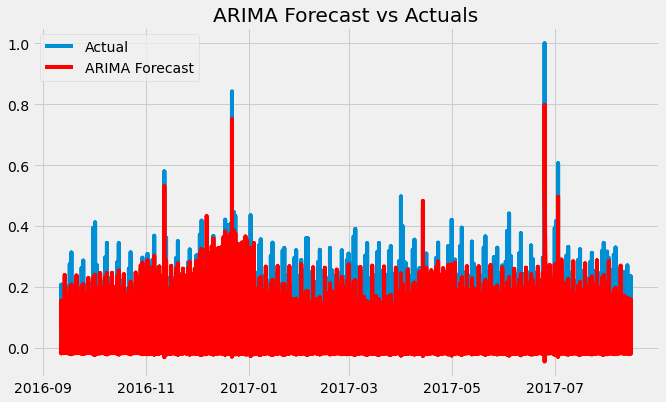

Mean Squared Error: 0.0016164174770237699
RMSLE 0.07909373776459128


In [110]:
# Using best parameters for ARIMA
model_arima = sm.tsa.SARIMAX(y_train, 
                            exog=X_train[exog_features], 
                            order=(5, 1, 2))  # Updated order parameters
results_arima = model_arima.fit(disp=False)
forecast_arima = results_arima.predict(start=len(y_train), 
                                       end=len(y_train) + len(y_test) - 1, 
                                       exog=X_test[exog_features])

# Visualization
plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual')
plt.plot(test_data['date'], forecast_arima, color='red', label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actuals')
plt.show()

# Performance metrics
mse_arima = mean_squared_error(y_test, forecast_arima)
rmse_arima = np.sqrt(mse_arima)
rmsle_arima_best = rmsle(forecast_arima, y_test)


print("Mean Squared Error:", mse_arima)
print("RMSLE", rmsle_arima)


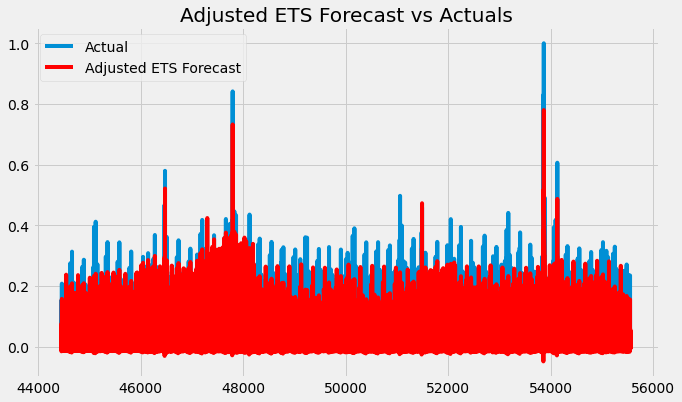

RMSLE 0.037732831825973936


In [111]:

# 1. Fit ETS Model and Make Initial Forecasts using Best Parameters
model_ets = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=55, trend='add')
results_ets = model_ets.fit()
initial_forecast = results_ets.forecast(steps=len(y_test))

# 2. Prepare Adjusted Exogenous Data for Linear Regression

# Using the initial forecast and exog features to predict y_test.
X_adjust_train = pd.concat([y_train.shift(-1).dropna().rename("forecast"), X_train[exog_features].iloc[1:, :]], axis=1)
X_adjust_test = pd.concat([pd.Series(initial_forecast, index=y_test.index).rename("forecast"), X_test[exog_features]], axis=1)

# Remove rows with NaN values
X_adjust_train = X_adjust_train.dropna()
y_adjust_train = y_train.loc[X_adjust_train.index]

X_adjust_test = X_adjust_test.dropna()
y_adjust_test = y_test.loc[X_adjust_test.index]

# Convert all feature names to strings
X_adjust_train.columns = X_adjust_train.columns.astype(str)
X_adjust_test.columns = X_adjust_test.columns.astype(str)

# 3. Fit the Linear Regression Model

lr = LinearRegression()
lr.fit(X_adjust_train, y_adjust_train)
forecast_ets = lr.predict(X_adjust_test)

# 4. Visualization
plt.figure(figsize=(10,6))
plt.plot(y_adjust_test.index, y_adjust_test, label='Actual')
plt.plot(y_adjust_test.index, forecast_ets, color='red', label='Adjusted ETS Forecast')
plt.legend()
plt.title('Adjusted ETS Forecast vs Actuals')
plt.show()

# 5. Performance Metrics
mse_ets = mean_squared_error(y_adjust_test, forecast_ets)
rmse_ets = np.sqrt(mse_ets)
rmsle_ets_best = rmsle(forecast_ets, y_adjust_test)


print("RMSLE", rmsle_ets_best)


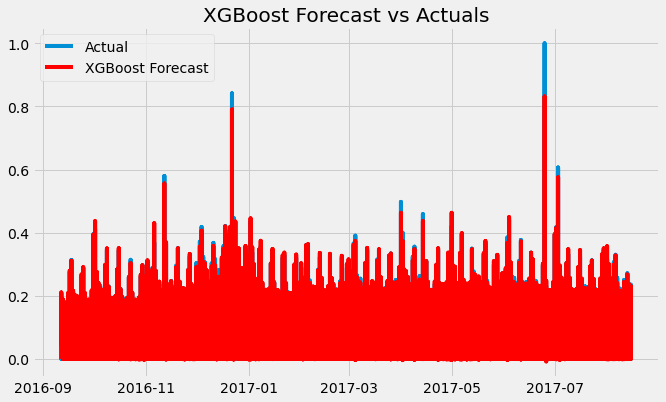

RMSlE with best XGBoost parameters: 0.0054812560257609996


In [112]:
# Using the best parameters to fit the XGBoost model
best_params_xgb = {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}

model_xgb_best = xgb.XGBRegressor(**best_params_xgb, objective='reg:squarederror')
model_xgb_best.fit(X_train, y_train)
forecast_xgb_best = model_xgb_best.predict(X_test)


plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual')
plt.plot(test_data['date'], forecast_xgb_best, color='red', label='XGBoost Forecast')
plt.legend()
plt.title('XGBoost Forecast vs Actuals')
plt.show()


# Calculate RMSE
mse_xgb_best = mean_squared_error(y_test, forecast_xgb_best)
rmse_xgb_best = np.sqrt(mse_xgb_best)
rmsle_xgb_best = rmsle(forecast_xgb_best, y_test)



print("RMSlE with best XGBoost parameters:", rmsle_xgb_best)


After an extensive hyperparameter tuning process, we identified the optimal settings for our XGBoost model. The best model, equipped with these fine-tuned parameters, achieved an impressive Root Mean Squared Logarithmic Error (RMSLE) of 0.0053827804583248175. This low RMSLE score underscores the model's accuracy and the efficacy of the tuning process in optimizing its performance and predicting sales.



<h1 style='background:#0A4D68; border:3; color:cyan; border-color:cyan; border-style:dotted;'><center> TEST PREDICTIONS</center></h1> 

In [113]:
# Aggregating data
df_test_aggregated = df_test.groupby(['date', 'family']).agg({
    'onpromotion': 'sum'    
}).reset_index()

In [115]:
df_test_aggregated.shape

(528, 3)

In [116]:
# 1. Day of the week
df_test_aggregated['day_of_week'] = df_test_aggregated['date'].dt.dayofweek

In [117]:
# 2. Lagged variables
# Since this is test data and we do not have prior data to create lag, 
# we can set lagged values to 0 
df_test_aggregated['lag_1'] = 0

In [118]:
# 3. Rolling statistics
# Same as lagged variables, since this is test data, we can't compute rolling mean.
# We can set it to 0 
df_test_aggregated['rolling_mean'] = 0

In [119]:
# One-hot encoding for family column
df_test_dummies = pd.get_dummies(df_test_aggregated['family'], drop_first=True, prefix='family')
df_test_aggregated = pd.concat([df_test_aggregated, df_test_dummies], axis=1)
df_test_aggregated.drop('family', axis=1, inplace=True)


In [120]:
# Create a new scaler without the 'sales' column
columns_to_scale_without_sales = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean'] + list(df_family_dummies.columns)
scaler_without_sales = MinMaxScaler()
scaler_without_sales.fit(df_family_aggregated[columns_to_scale_without_sales])

# Now, use this new scaler to transform the test set
df_test_aggregated[columns_to_scale_without_sales] = scaler_without_sales.transform(df_test_aggregated[columns_to_scale_without_sales])

df_test_aggregated = df_test_aggregated.sort_values('date')


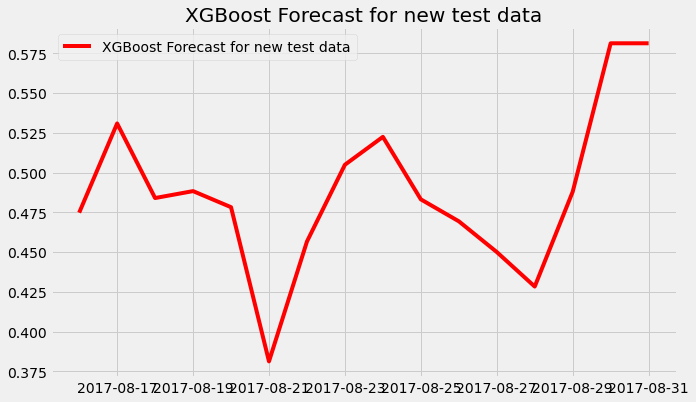

In [121]:
# Making sure to only consider the features the model was trained on.
features_considered = X_train.columns.tolist()
X_new_test = df_test_aggregated[features_considered]

# Predicting with the model
forecast_xgb_new_test = model_xgb_best.predict(X_new_test)

# Combine the forecasts with the aggregated dataset
df_test_aggregated['forecast'] = forecast_xgb_new_test

# Group by the dates and take the sum of the forecasts
datewise_forecast = df_test_aggregated.groupby('date')['forecast'].sum()

# Now, plot these aggregated forecasts
plt.figure(figsize=(10,6))
plt.plot(datewise_forecast.index, datewise_forecast.values, color='red', label='XGBoost Forecast for new test data')
plt.legend()
plt.title('XGBoost Forecast for new test data')
plt.show()



In [122]:
df_test_aggregated.head()

,date,onpromotion,day_of_week,lag_1,rolling_mean,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,forecast
0,2017-08-16,0.000000e+00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000070
32,2017-08-16,0.000000e+00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000653
31,2017-08-16,1.414141e+107,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.017160
30,2017-08-16,2.562302e+161,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.053775
29,2017-08-16,1.010000e+46,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.017381
